<a href="https://colab.research.google.com/github/DenisPotekhin2002/Generative-Models-2025/blob/main/Assignment%201/1_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025**

## Assignment 1


In this assignment we implement DDPM - Denoising Diffusion Probabilistic Models (2020)

In simple terms, we get an image from data and add noise step by step. Then We train a model to predict that noise at each step and use the model to generate images.

The following definitions and derivations show how this works. For details please refer to the paper https://arxiv.org/abs/2006.11239

## Forward Process

The forward process adds noise to the data $x_0 \sim q(x_0)$, for $T$ timesteps.

\begin{align}
q(x_t | x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{1-  \beta_t} x_{t-1}, \beta_t \mathbf{I}\big) \\
q(x_{1:T} | x_0) = \prod_{t = 1}^{T} q(x_t | x_{t-1})
\end{align}

where $\beta_1, \dots, \beta_T$ is the variance schedule.

We can sample $x_t$ at any timestep $t$ with,

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

where $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$

## Reverse Process

The reverse process removes noise starting at $p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
for $T$ time steps.

\begin{align}
p_\theta(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
 \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)\big) \\
p_\theta(x_{0:T}) &= p_\theta(x_T) \prod_{t = 1}^{T} p_\theta(x_{t-1} | x_t) \\
p_\theta(x_0) &= \int p_\theta(x_{0:T}) dx_{1:T}
\end{align}

$\theta$ are the parameters we train.

## Loss

We optimize the ELBO (from Jenson's inequality) on the negative log likelihood.

\begin{align}
\mathbb{E}[-\log p_\theta(x_0)]
 &\le \mathbb{E}_q [ -\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} ] \\
 &=L
\end{align}

The loss can be rewritten as  follows.

\begin{align}
L
 &= \mathbb{E}_q [ -\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} ] \\
 &= \mathbb{E}_q [ -\log p(x_T) - \sum_{t=1}^T \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} ] \\
 &= \mathbb{E}_q [
  -\log \frac{p(x_T)}{q(x_T|x_0)}
  -\sum_{t=2}^T \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t,x_0)}
  -\log p_\theta(x_0|x_1)] \\
 &= \mathbb{E}_q [
   D_{KL}(q(x_T|x_0) \Vert p(x_T))
  +\sum_{t=2}^T D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t))
  -\log p_\theta(x_0|x_1)]
\end{align}

$D_{KL}(q(x_T|x_0) \Vert p(x_T))$ is constant since we keep $\beta_1, \dots, \beta_T$ constant.

### Computing $L_{t-1} = D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t))$

The forward process posterior conditioned by $x_0$ is,

\begin{align}
q(x_{t-1}|x_t, x_0) &= \mathcal{N} \Big(x_{t-1}; \tilde\mu_t(x_t, x_0), \tilde\beta_t \mathbf{I} \Big) \\
\tilde\mu_t(x_t, x_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}x_0
                         + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})}{1-\bar\alpha_t}x_t \\
\tilde\beta_t &= \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t
\end{align}

The paper sets $\Sigma_\theta(x_t, t) = \sigma_t^2 \mathbf{I}$ where $\sigma_t^2$ is set to constants
$\beta_t$ or $\tilde\beta_t$.

Then,
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I} \big)$$

For given noise $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ using $q(x_t|x_0)$

\begin{align}
x_t(x_0, \epsilon) &= \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon \\
x_0 &= \frac{1}{\sqrt{\bar\alpha_t}} \Big(x_t(x_0, \epsilon) -  \sqrt{1-\bar\alpha_t}\epsilon\Big)
\end{align}

This gives,

\begin{align}
L_{t-1}
 &= D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t)) \\
 &= \mathbb{E}_q \Bigg[ \frac{1}{2\sigma_t^2}
 \Big \Vert \tilde\mu(x_t, x_0) - \mu_\theta(x_t, t) \Big \Vert^2 \Bigg] \\
 &= \mathbb{E}_{x_0, \epsilon} \Bigg[ \frac{1}{2\sigma_t^2}
  \bigg\Vert \frac{1}{\sqrt{\alpha_t}} \Big(
  x_t(x_0, \epsilon) - \frac{\beta_t}{\sqrt{1 - \bar\alpha_t}} \epsilon
  \Big) - \mu_\theta(x_t(x_0, \epsilon), t) \bigg\Vert^2 \Bigg] \\
\end{align}

Re-parameterizing with a model to predict noise

\begin{align}
\mu_\theta(x_t, t) &= \tilde\mu \bigg(x_t,
  \frac{1}{\sqrt{\bar\alpha_t}} \Big(x_t -
   \sqrt{1-\bar\alpha_t}\epsilon_\theta(x_t, t) \Big) \bigg) \\
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
  \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)
\end{align}

where $\epsilon_\theta$ is a learned function that predicts $\epsilon$ given $(x_t, t)$.

This gives,

\begin{align}
L_{t-1}
&= \mathbb{E}_{x_0, \epsilon} \Bigg[ \frac{\beta_t^2}{2\sigma_t^2 \alpha_t (1 - \bar\alpha_t)}
  \Big\Vert
  \epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
  \Big\Vert^2 \Bigg]
\end{align}

That is, we are training to predict the noise.

### Simplified loss

$$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

This minimizes $-\log p_\theta(x_0|x_1)$ when $t=1$ and $L_{t-1}$ for $t\gt1$ discarding the
weighting in $L_{t-1}$. Discarding the weights $\frac{\beta_t^2}{2\sigma_t^2 \alpha_t (1 - \bar\alpha_t)}$
increase the weight given to higher $t$ (which have higher noise levels), therefore increasing the sample quality.

This file implements the loss calculation and a basic sampling method that we use to generate images during
training.

$\epsilon_\theta(x_t, t)$ is a UNet model.

In [1]:
from typing import List, Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load file unet.py to the filesystem of colab
from unet import UNet

/content/unet.py:12: SyntaxWarning: invalid escape sequence '\c'
  $$x \cdot \sigma(x)$$


In [3]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for t and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

### Explanations to the code
[1] $\bar\alpha_t = \prod_{s=1}^t \alpha_s$

[2] \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}

[3] gather $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$

[4] $(1-\bar\alpha_t) \mathbf{I}$

[5] \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}

[6] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[7] \begin{align}
        p_\theta(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \mu_\theta(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)
        \end{align}

[8] gather $\bar\alpha_t$

[9] $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$

[10] $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
              \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$$

[11] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[12] $$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
        \epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
        \bigg\Vert^2 \Bigg]$$

[13] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[14] Get $\epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)$

In [4]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * eps_model - epsilon_theta(x_t, t) model
        * n_steps - t
        * device - the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create beta_1 ... beta_T linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # alpha_t = 1 - beta_t
        self.alpha = 1 - self.beta
        # [1]
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # T
        self.n_steps = n_steps
        # sigma^2 = beta
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get q(x_t|x_0) distribution

        [2]
        """
        # [3]
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # [4]
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        Sample from q(x_t|x_0)

        [5]
        """

        # [6]
        if eps is None:
            eps = torch.randn_like(x0)

        # get q(x_t|x_0)
        mean, var = self.q_xt_x0(x0, t)
        # Sample from q(x_t|x_0)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        Sample from p_theta(x_{t-1}|x_t)

        [7]
        """

        # epsilon_theta(x_t, t)
        eps_theta = self.eps_model(xt, t)
        # [8]
        alpha_bar = gather(self.alpha_bar, t)
        # alpha_t
        alpha = gather(self.alpha, t)
        # [9]
        eps_coef = (1 - alpha) / (1 - alpha_bar).sqrt()
        # [10]
        mean = (xt - eps_coef * eps_theta) / alpha.sqrt()
        # sigma^2
        var = gather(self.sigma2, t)

        # [11]
        eps = torch.randn_like(xt)
        # Sample
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        Simplified Loss

        [12]
        """
        # Get batch size
        batch_size = x0.shape[0]
        # Get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # [13]
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample x_t for q(x_t|x_0)
        xt = self.q_sample(x0, t, eps=noise)
        # [14]
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.mse_loss(noise, eps_theta)

### Explanations to the code
[1] $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$

[2] Sample from $p_\theta(x_{t-1}|x_t)$



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]
Sampling: 100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s]


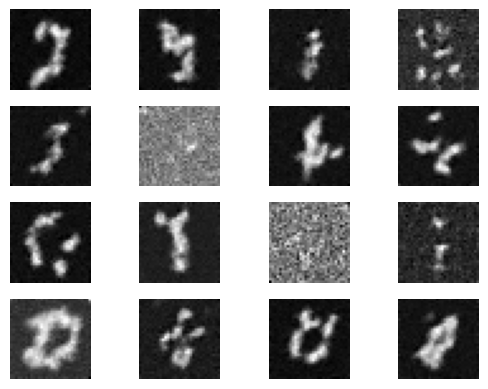

Sampling: 100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]


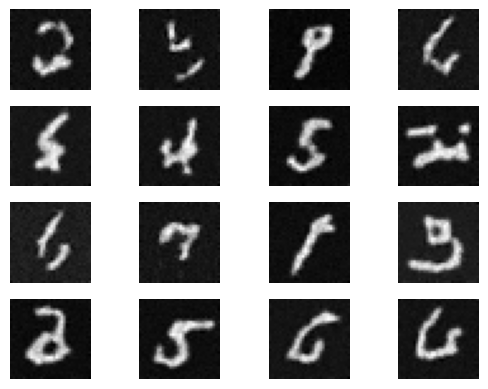

Sampling: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


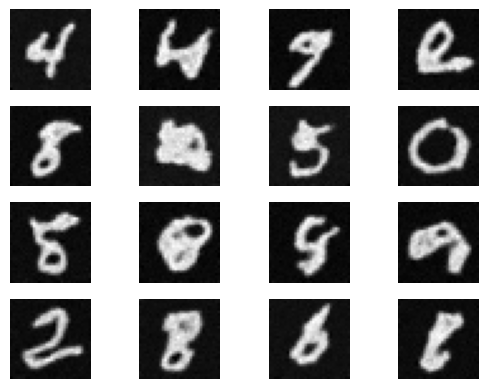

Sampling: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


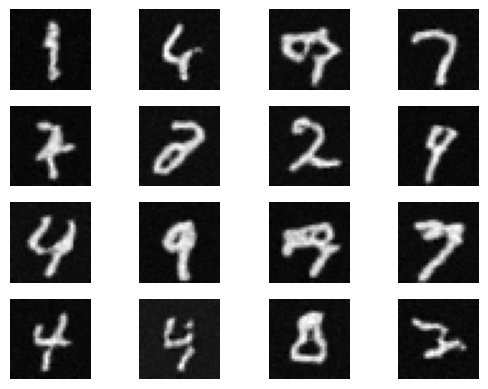

Sampling: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


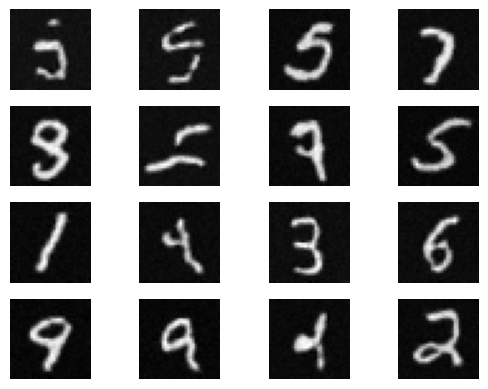

In [5]:
class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__("data", train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

def plot_samples(tensor):
    # Assuming you have a tensor of size torch.Size([16, 1, 32, 32])
    # Convert the tensor to a numpy array
    images = tensor.numpy()

    # Reshape the images to be of size (16, 32, 32)
    images = np.reshape(images, (16, 32, 32))

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=4, ncols=4)

    # Iterate over the images and plot them on the subplots
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    # Show the plot
    plt.show()


class Configs:
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # U-Net model for epsilon_theta(x_t, t)
    eps_model: UNet
    # DDPM algorithm
    diffusion: DenoiseDiffusion

    # Number of channels in the image. 3 for RGB.
    image_channels: int = 1
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps T
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 5

    # Dataset
    dataset: torch.utils.data.Dataset = MNISTDataset(image_size)
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create epsilon_theta(x_t, t) model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        # Create DDPM class
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

    def sample(self):
        with torch.no_grad():
            # [1]
            x = torch.randn((self.n_samples, self.image_channels, self.image_size, self.image_size), device=self.device)

            # Remove noise for T steps
            progress_bar = tqdm(range(self.n_steps))
            for t_ in progress_bar:
                progress_bar.set_description(f"Sampling")
                # t
                t = self.n_steps - t_ - 1
                # [2]
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log samples
            plot_samples(x.detach().cpu())

    def train(self, epoch):
        # Iterate through the dataset
        progress_bar = tqdm(self.data_loader)
        for data in progress_bar:
            # Increment global step
            progress_bar.set_description(f"Epoch {epoch + 1}")
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()

            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()

            # Take an optimization step
            self.optimizer.step()

            # Track the loss
            progress_bar.set_postfix(loss=loss.detach().cpu().numpy())

    def run(self):
        for epoch in range(self.epochs):
            # Train the model
            self.train(epoch)
            # Sample some images
            self.sample()


# Create configurations
configs = Configs()

# Initialize
configs.init()

# Start and run the training loop
configs.run()